In [1]:
import pandas as pd
import nltk

from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
import matplotlib.pyplot as plt
from sklearn.metrics import f1_score, accuracy_score


In [2]:
import nltk
nltk.download(['punkt', 'stopwords'])


[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

In [3]:
df = pd.read_csv("selected_data.csv")

ParserError: ignored

In [ ]:
df.head()

In [ ]:
def preprocess_text(text):
    # Convert to lowercase
    text = text.lower()

    # Tokenization
    tokens = word_tokenize(text)

    # Remove punctuation and special characters
    tokens = [word for word in tokens if word.isalnum()]

    # Remove stopwords
    stop_words = set(stopwords.words('english'))
    tokens = [word for word in tokens if word not in stop_words]

    # Stemming
    stemmer = PorterStemmer()
    tokens = [stemmer.stem(word) for word in tokens]

    # Join the tokens back into a string
    preprocessed_text = ' '.join(tokens)

    return preprocessed_text

In [ ]:
df_preprocessed = df.copy()
df_preprocessed['reviewText'] = df_preprocessed['reviewText'].apply(preprocess_text)
df_preprocessed.to_csv('data_preprocessed.csv', index=False)


In [ ]:
import pandas as pd
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import RandomOverSampler

# Read the preprocessed CSV file
df_preprocessed = pd.read_csv('data_preprocessed.csv')

# Split the data into training and validation sets
train_data, valid_data = train_test_split(df_preprocessed, test_size=0.2, random_state=42)

# Balance the classes only for the training set
ros = RandomOverSampler(random_state=42)
X_train_resampled, y_train_resampled = ros.fit_resample(train_data['reviewText'].values.reshape(-1, 1), train_data['overall'])

# Convert the resampled data back to a DataFrame
train_df = pd.DataFrame({'reviewText': X_train_resampled.flatten(), 'overall': y_train_resampled})

# Save the balanced training data and the validation data to CSV
train_df.to_csv('train_data.csv', index=False)
valid_data.to_csv('valid_data.csv', index=False)


In [ ]:
print(train_df['overall'].value_counts())


4    3589
1    3589
5    3589
2    3589
3    3589
Name: overall, dtype: int64


In [ ]:
print(valid_data['overall'].value_counts())


5    905
4    258
3    153
1    145
2     84
Name: overall, dtype: int64


In [ ]:
from sklearn.model_selection import train_test_split
df_preprocessed = pd.read_csv('data_preprocessed.csv')
train_data, valid_data = train_test_split(df_preprocessed, test_size=0.2, random_state=42)
train_data.to_csv('train_data.csv', index=False)
valid_data.to_csv('valid_data.csv', index=False)

In [ ]:
!pip install transformers

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.9/7.9 MB 56.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 311.2/311.2 kB 43.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.8/3.8 MB 103.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 86.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 295.0/295.0 kB 34.3 MB/s eta 0:00:00


In [ ]:
import pandas as pd
from sklearn.model_selection import train_test_split
from transformers import DistilBertTokenizer, DistilBertForSequenceClassification, AdamW
from torch.utils.data import DataLoader, Dataset
from tqdm import tqdm
import torch
from sklearn.metrics import accuracy_score
from torch import nn
from torch.optim import Adam

In [ ]:
train_data = pd.read_csv('train_data.csv')
valid_data = pd.read_csv('valid_data.csv')

In [ ]:
train_data.head()

,reviewText,overall
0,dual monitor pc one dvi one vga port adapt per...,4
1,excel stabil 18 power binocular cheap worth pr...,4
2,first time order len receiv wrong len wrong si...,1
3,ok fed new modern electron devic everi singl b...,5
4,unit good deal work 2 major complaint go back ...,2


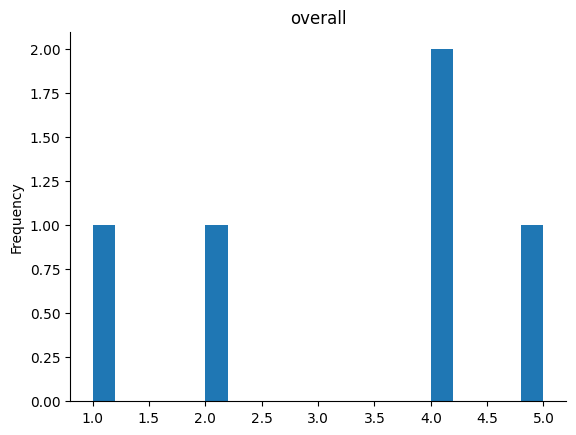

In [ ]:
from matplotlib import pyplot as plt
_df_0['overall'].plot(kind='hist', bins=20, title='overall')
plt.gca().spines[['top', 'right',]].set_visible(False)

In [ ]:
class CustomDataset(Dataset):
    def __init__(self, texts, labels):
        self.texts = texts
        self.labels = labels

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, idx):
        return {'text': str(self.texts.iloc[idx]), 'label': int(self.labels.iloc[idx])}

In [ ]:
train_dataset = CustomDataset(train_data['reviewText'], train_data['overall'])
valid_dataset = CustomDataset(valid_data['reviewText'], valid_data['overall'])

In [ ]:
tokenizer = DistilBertTokenizer.from_pretrained('distilbert-base-uncased')
train_encodings = tokenizer(list(train_dataset.texts), truncation=True, padding=True)
valid_encodings = tokenizer(list(valid_dataset.texts), truncation=True, padding=True)

In [ ]:
# Convert data to PyTorch tensors
train_labels = torch.tensor(list(train_dataset.labels))
valid_labels = torch.tensor(list(valid_dataset.labels))

In [ ]:
class CustomDataset(Dataset):
    def __init__(self, encodings, labels):
        self.encodings = encodings
        self.labels = labels

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
        item['labels'] = torch.tensor(self.labels[idx])
        return item

In [ ]:
train_dataset = CustomDataset(train_encodings, train_labels)
valid_dataset = CustomDataset(valid_encodings, valid_labels)

In [ ]:
model = DistilBertForSequenceClassification.from_pretrained('distilbert-base-uncased', num_labels=5)


Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['pre_classifier.weight', 'classifier.bias', 'pre_classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [ ]:
optimizer = AdamW(model.parameters(), lr=5e-5)
loss_fn = nn.CrossEntropyLoss()

In [ ]:
from torch.optim.lr_scheduler import ReduceLROnPlateau

scheduler = ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=2, verbose=True)


In [ ]:
train_loader = DataLoader(train_dataset, batch_size=8, shuffle=True)
valid_loader = DataLoader(valid_dataset, batch_size=8, shuffle=False)

In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)

RuntimeError: ignored

In [ ]:

epochs = 15
train_losses = []
valid_losses = []
val_accuracies = []
val_f1_micros = []

for epoch in range(epochs):
    model.train()
    total_loss = 0
    for batch in tqdm(train_loader, desc=f'Epoch {epoch + 1}', position=0, leave=True):
        optimizer.zero_grad()
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        labels = batch['labels'].to(device)

        labels = labels +1 1

        outputs = model(input_ids, attention_mask=attention_mask, labels=labels)
        loss = outputs.loss
        total_loss += loss.item()
        loss.backward()
        optimizer.step()

    avg_loss = total_loss / len(train_loader)
    train_losses.append(avg_loss)
    print(f'Average training loss for Epoch {epoch + 1}: {avg_loss}')

    # Validation loop
    model.eval()
    val_preds = []
    val_true = []
    val_loss = 0

    with torch.no_grad():
        for batch in tqdm(valid_loader, desc=f'Validation', position=0, leave=True):
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            labels = batch['labels'].to(device)

            labels = labels + 1

            outputs = model(input_ids, attention_mask=attention_mask, labels=labels)
            loss = outputs.loss
            val_loss += loss.item()

            logits = outputs.logits
            preds = torch.argmax(logits, dim=1)
            val_preds.extend(preds.cpu().numpy())
            val_true.extend(labels.cpu().numpy())

    avg_val_loss = val_loss / len(valid_loader)
    valid_losses.append(avg_val_loss)

    val_accuracy = accuracy_score(val_true, val_preds)
    val_f1_micro = f1_score(val_true, val_preds, average='micro')

    val_accuracies.append(val_accuracy)
    val_f1_micros.append(val_f1_micro)

    print(f'Validation Accuracy for Epoch {epoch + 1}: {val_accuracy}')
    print(f'Validation F1 Score (micro) for Epoch {epoch + 1}: {val_f1_micro}')
    print(f'Average training loss for Epoch {epoch + 1}: {avg_loss}')

    # Update learning rate based on validation loss
    scheduler.step(avg_val_loss)

    # Early stopping
    if epoch > 0 and avg_val_loss > valid_losses[-1]:
        print(f'Early stopping at Epoch {epoch + 1}')
        break

# Plotting the training and validation loss
plt.plot(train_losses, label='Training Loss')
plt.plot(valid_losses, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

Epoch 1:   0%|          | 0/2244 [00:00<?, ?it/s]<ipython-input-18-01eed219a6c2>:11: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  item['labels'] = torch.tensor(self.labels[idx])
Epoch 1:   0%|          | 0/2244 [00:03<?, ?it/s]


RuntimeError: ignored

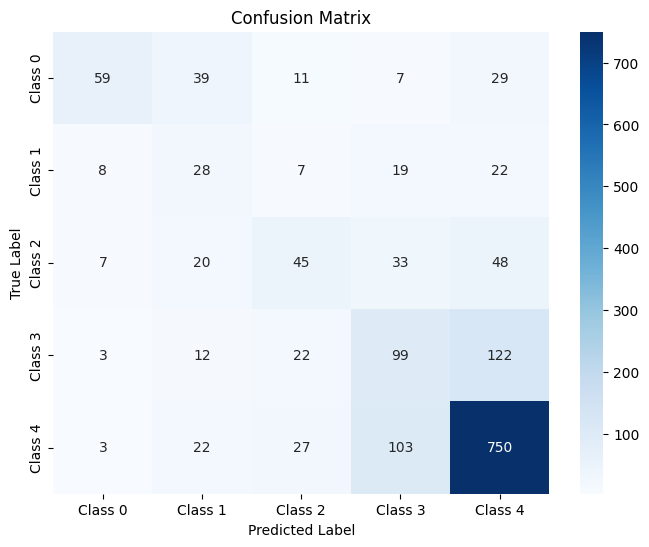

In [ ]:
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns

conf_mat = confusion_matrix(val_true, val_preds)
class_labels = ["Class 0", "Class 1", "Class 2", "Class 3", "Class 4"]
conf_df = pd.DataFrame(conf_mat, index=class_labels, columns=class_labels)

# Plot the heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(conf_df, annot=True, cmap="Blues", fmt="d", cbar=True)
plt.title("Confusion Matrix")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()

In [ ]:
misclassified_indices = [i for i, (true_label, pred_label) in enumerate(zip(val_true, val_preds)) if true_label == 1 and pred_label != 1]

# Display misclassified examples
for index in misclassified_indices:
    print(f"True Label: {val_true[index]}, Predicted Label: {val_preds[index]}")
    print(f"Review Text: {valid_data['reviewText'].iloc[index]}\n")

True Label: 1, Predicted Label: 0
Review Text: bought encod work well xsplit stream avermedia ui clunki cumbersom need tri make thing fanci make straight forward interfac expect learn curv srsli ps believ sponsor streamer hype deal support like pull teeth also eff suppos made hardcor gamer eve support 1m 144mhz refresh rate dude realli dumb hype machin corpor fool much hype behind capit gamer want great hardwar believ buy truth junk cant support 144mhz need realiti us get stop hype ur turd product avermedia also bought mine use note list come month free despit say everyth box

True Label: 1, Predicted Label: 3
Review Text: realli work work dimmer display lot even much kinda disappoint love 3m compani product extrem expens way work

True Label: 1, Predicted Label: 4
Review Text: pretti good price work get connect issu even year usag liter stay offic like rough hous either spend littl get sturdier pair

True Label: 1, Predicted Label: 3
Review Text: cord warm touch tell gaug wire thin us

In [ ]:
df_test = pd.read_csv("selected_data.csv")

In [ ]:
model.save_pretrained('path_to_save_model_weights')
